In [93]:
from math import sqrt
from numpy import concatenate
from numpy import array
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('AI_Lec_23_final_stocks.csv', header=None, sep='\t')
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_features = 100
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
train = values[:int(len(values) * 0.8), :]
test = values[int(len(values) * 0.8):, :]
# split into input and outputs
n_obs = n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, n_features))
test_X = test_X.reshape((test_X.shape[0], 1, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)



(2999, 200)
(2399, 100) 2399 (2399,)
(2399, 1, 100) (2399,) (600, 1, 100) (600,)
Epoch 1/50
34/34 - 3s - loss: 0.0434 - val_loss: 0.1855 - 3s/epoch - 96ms/step
Epoch 2/50
34/34 - 0s - loss: 0.1250 - val_loss: 0.1913 - 152ms/epoch - 4ms/step
Epoch 3/50
34/34 - 0s - loss: 0.0710 - val_loss: 0.0894 - 134ms/epoch - 4ms/step
Epoch 4/50
34/34 - 0s - loss: 0.0678 - val_loss: 0.0279 - 143ms/epoch - 4ms/step
Epoch 5/50
34/34 - 0s - loss: 0.0590 - val_loss: 0.0330 - 143ms/epoch - 4ms/step
Epoch 6/50
34/34 - 0s - loss: 0.0469 - val_loss: 0.0378 - 149ms/epoch - 4ms/step
Epoch 7/50
34/34 - 0s - loss: 0.0180 - val_loss: 0.0747 - 195ms/epoch - 6ms/step
Epoch 8/50
34/34 - 0s - loss: 0.0226 - val_loss: 0.0636 - 203ms/epoch - 6ms/step
Epoch 9/50
34/34 - 0s - loss: 0.0237 - val_loss: 0.0496 - 224ms/epoch - 7ms/step
Epoch 10/50
34/34 - 0s - loss: 0.0163 - val_loss: 0.0545 - 224ms/epoch - 7ms/step
Epoch 11/50
34/34 - 0s - loss: 0.0281 - val_loss: 0.0243 - 245ms/epoch - 7ms/step
Epoch 12/50
34/34 - 0s - los

In [95]:
res = []
pred = test_X

ds = dataset.values
for i in range(20):
  yhat = model.predict(pred)

  pred = pred.reshape((pred.shape[0], n_features))
  inv_yhat = concatenate((yhat, pred[:, -(n_features-1):]), axis=1)

  lst = []
  for i in range(100):
    lst.append(ds[-1][i] * inv_yhat[-1][i] / scaled[-1][i])
  res.append(lst)
  lst = array(lst).reshape((1, 100))
  ds = concatenate((ds,lst))
  # dataset = dataset
  pred = pred.reshape((pred.shape[0], 1, n_features))
res = DataFrame(array(res))
df = DataFrame.from_dict(res)
df.to_csv('result.csv')

 1/19 [>.............................] - ETA: 0s

<ipython-input-95-05d24375cb26>:13: RuntimeWarning: divide by zero encountered in double_scalars
  lst.append(ds[-1][i] * inv_yhat[-1][i] / scaled[-1][i])


19/19 [==============================] - 0s 2ms/step


Test RMSE: 3.885


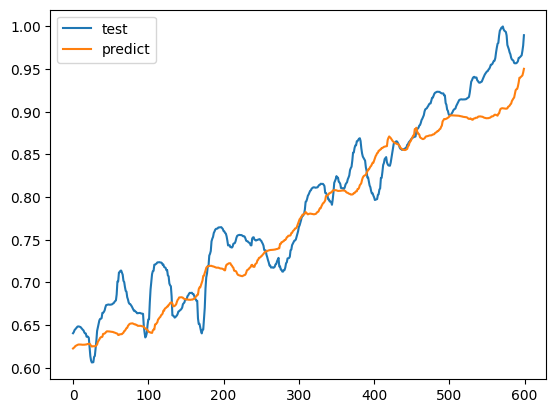

In [96]:
test_X = test_X.reshape((test_X.shape[0], n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

pyplot.figure()
pyplot.plot(test_y, label='test')
pyplot.plot(yhat, label='predict')
pyplot.legend()